In [203]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

import glob
import os

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cpu


In [126]:
class AnimeDataset(Dataset):
  def __init__(self, path, transform):
    super(AnimeDataset, self).__init__()
    self.path = path
    self.transform = transform
    self.images = glob.glob(os.path.join(self.path, '*'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    X = self.transform(Image.open(self.images[index]))
    return X

  def __repr__(self):
    return f"<AnimeDataset len:{len(self.images)}>"

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(0.0, 1.0)
])

dataset = AnimeDataset('./images', transform)

In [212]:
train_dl = DataLoader(dataset, 32, shuffle=True)

X_batch = next(iter(train_dl))

In [153]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(ch_in, ch_out, 3, 2, 1, bias=False),
      nn.BatchNorm2d(ch_out),
      nn.LeakyReLU(0.02)
    )
  def forward(self, X):
    return self.block(X)

In [209]:
class ConvTBlock(nn.Module):
  def __init__(self, ch_in, ch_out, dropout = True, sigmoid=False):
    super(ConvTBlock, self).__init__()
    self.block = nn.Sequential(
      nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, output_padding=1),
      nn.Dropout2d(0.25) if dropout else nn.Identity(),
      nn.Sigmoid() if sigmoid else nn.ReLU()
    )
  def forward(self, X):
    return self.block(X)

In [311]:
X_batch

encoder = nn.Sequential(
  ConvBlock(3, 32),
  ConvBlock(32, 64),
  ConvBlock(64, 128),
  ConvBlock(128, 256),
  ConvBlock(256, 512),
  nn.Conv2d(512, 512, 2),
  nn.Tanh()
)

decoder = nn.Sequential(
  nn.ConvTranspose2d(512, 512, 2),
  nn.ReLU(),
  ConvTBlock(512, 256),
  ConvTBlock(256, 128),
  ConvTBlock(128, 64),
  ConvTBlock(64, 32),
  ConvTBlock(32, 3, False, True),
)

model = nn.Sequential(
    encoder,
    decoder
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
loss_fn = nn.BCELoss()

output = decoder(encoder(X_batch))

In [619]:
for i in range(22):
  train_loss = .0
  for X_batch in tqdm(train_dl):
    
    model.train()
    fake = model(X_batch)

    loss = loss_fn(fake, X_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * X_batch.shape[0]
  
  train_loss /= len(train_dl.dataset)

  print(train_loss)

100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


0.5206483668984606


100%|██████████| 98/98 [00:29<00:00,  3.30it/s]


0.5207941570712832


100%|██████████| 98/98 [00:30<00:00,  3.21it/s]


0.5209209849459359


100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


0.5206656171243491


100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


0.5206585211923435


100%|██████████| 98/98 [00:29<00:00,  3.32it/s]


0.5207511562638006


100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


0.5205238870381164


100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


0.5203758977384607


100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


0.5205242438447739


100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


0.5204842141216208


100%|██████████| 98/98 [00:29<00:00,  3.33it/s]


0.5203123735010299


100%|██████████| 98/98 [00:29<00:00,  3.33it/s]


0.5204007961130493


100%|██████████| 98/98 [00:29<00:00,  3.30it/s]


0.5201069007161259


100%|██████████| 98/98 [00:29<00:00,  3.35it/s]


0.5202822389605717


100%|██████████| 98/98 [00:29<00:00,  3.30it/s]


0.5201637110279295


100%|██████████| 98/98 [00:29<00:00,  3.30it/s]


0.5201211642546747


100%|██████████| 98/98 [00:29<00:00,  3.32it/s]


0.5199733211305881


100%|██████████| 98/98 [00:29<00:00,  3.33it/s]


0.5201343855427


100%|██████████| 98/98 [00:29<00:00,  3.31it/s]


0.5201724760809681


100%|██████████| 98/98 [00:29<00:00,  3.32it/s]


0.5202074748168806


100%|██████████| 98/98 [00:28<00:00,  3.40it/s]


0.5198466025152026


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]

0.5196710757359753


In [627]:
train_loss

0.5196710757359753

In [621]:
X_batch.shape

torch.Size([17, 3, 64, 64])

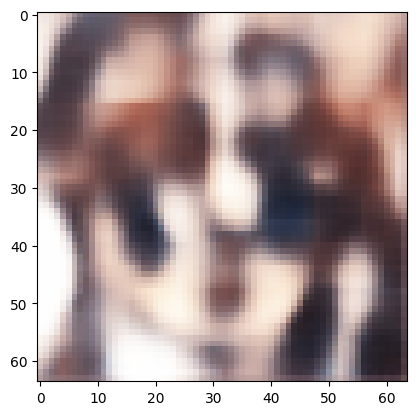

In [655]:
shape = encoder(torch.rand(1, 3, 64, 64)).shape

plt.imshow(decoder(torch.randn(shape)**2)[0].moveaxis(0, 2).detach().numpy())

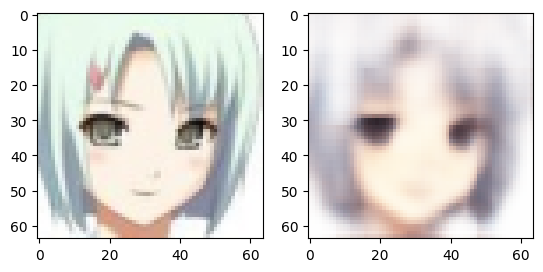

In [631]:
X_batch = next(iter(train_dl))

model.eval()
fake = model(X_batch[:1,:,:,:])

plt.subplot(1, 2, 1)
plt.imshow(X_batch[0].moveaxis(0, 2).numpy())
plt.subplot(1, 2, 2)
plt.imshow(fake.detach()[0].moveaxis(0, 2).numpy())